In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512


In [2]:
x = torch.randn((batch_size, sequence_length, input_dim))


In [3]:
x.shape

torch.Size([1, 4, 512])

We're using PyTorch's `nn.Linear` module to define a linear transformation layer, often called a "fully connected layer" or "dense layer." Here's a breakdown of what's happening:

- `nn.Linear(input_dim, 3 * d_model)`:
  - This line creates an instance of the `nn.Linear` module.
  - `input_dim` represents the size of each input sample (the last dimension of `x`).
  - `3 * d_model` represents the output size of the linear layer. Here, we're using `3 * d_model` becausme in transformer architectures, the input is split into queries, keys, and values. Each of these components gets its own linear transformation, hence the factor of 3.

- `qkv_layer(x)`:
  - This line applies the linear transformation defined by `qkv_layer` to the input tensor `x`.
  - The input tensor `x` has a shape of `(batch_size, sequence_length, input_dim)`.
  - The output tensor `qkv` will have a shape
  of `(batch_size, sequence_length, 3 * d_model)`, as each input sample is transformed into three separate parts: queries, keys, and values, each with a dimensionality of `d_model`.

So, essentially, `qkv_layer` is used to linearly transform the input tensor `x` into a tensor `qkv` where each input sample is split into queries, keys, and values for further processing in self-attention mechanism.

In [4]:
qkv_layer = nn.Linear(input_dim, 3 * d_model)
qkv = qkv_layer(x)


Text(0.5, 1.0, 'qkv distribution')

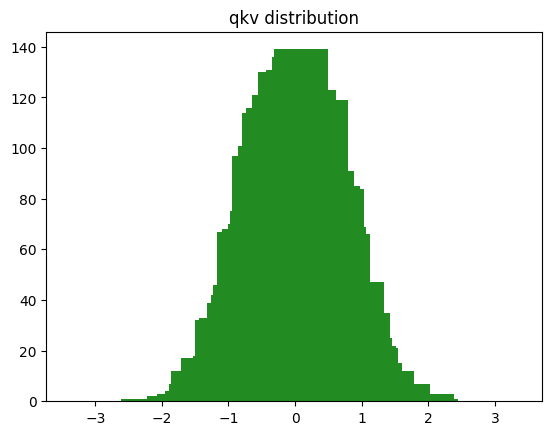

In [5]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')


In transformer-based architectures, such as the Transformer model used in natural language processing tasks, multi-head attention is a key component. This operation is designed to capture different aspects of the input sequence in parallel. The `num_heads` parameter controls how many heads are used in the multi-head attention mechanism.

Here's a detailed explanation:

- **`num_heads = 8`:**
  - This line defines the number of attention heads. Each head is a separate attention mechanism that operates in parallel.

- **`head_dim = d_model // num_heads`:**
  - This line calculates the dimensionality of each head. It divides the total model dimension (`d_model`) by the number of heads (`num_heads`).
  - For example, if `d_model = 512` and `num_heads = 8`, then `head_dim` would be `512 // 8 = 64`. This means each head will have a dimensionality of 64.

- **`qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)`:**
  - This line reshapes the `qkv` tensor to split it into `num_heads` separate heads.
  - The `reshape` function is used to reshape the tensor while preserving its total number of elements.
  - The shape of the tensor is changed to `(batch_size, sequence_length, num_heads, 3 * head_dim)`.
    - `batch_size`: The number of samples in the batch.
    - `sequence_length`: The length of each sequence.
    - `num_heads`: The number of attention heads.
    - `3 * head_dim`: The total dimensionality of the queries, keys, and values concatenated together for each head.
  - This reshaping operation essentially splits the tensor along its third dimension into multiple heads, allowing each head to perform attention independently.

In summary, this code prepares the `qkv` tensor for multi-head attention by reshaping it to have a separate dimension for each attention head, along with the concatenated queries, keys, and values for each head. This facilitates parallel processing of the input sequence by multiple attention mechanisms.


In [7]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)
print(qkv.shape)

torch.Size([1, 4, 8, 192])


Certainly! Let's break down the code step by step:

**`qkv = qkv.permute(0, 2, 1, 3):`**

- This line permutes the dimensions of the `qkv` tensor.
- The parameters `(0, 2, 1, 3)` indicate the new order of dimensions after permutation:
  - `0`: Represents the batch dimension, which remains unchanged.
  - `2` and `1`: Swap the positions of the second and third dimensions.
  - `3`: Represents the last dimension, which also remains unchanged.
- The effect of this permutation is to swap the dimensions corresponding to the sequence length and the number of heads. After this operation, the tensor shape becomes `(batch_size, num_heads, sequence_length, 3 * head_dim)`.
- This permutation is necessary to align the dimensions properly for further processing in multi-head attention. Specifically, it ensures that each head operates over the sequence length dimension.

**`q, k, v = qkv.chunk(3, dim=-1):`**

- This line splits the `qkv` tensor into three separate tensors: queries (`q`), keys (`k`), and values (`v`), along the last dimension (dimension `-1`).
- The `chunk` function divides the tensor into a specified number of chunks along a given dimension.
- Here, we split the tensor into three chunks because the `qkv` tensor contains concatenated queries, keys, and values for each head.
- After splitting, each resulting tensor (`q`, `k`, `v`) contains the corresponding queries, keys, and values for all heads.
- The resulting shapes of `q`, `k`, and `v` tensors are `(batch_size, num_heads, sequence_length, head_dim)`.

In summary, these operations prepare the `q`, `k`, and `v` tensors for use in the multi-head attention mechanism by properly arranging their dimensions and splitting them into separate components for each head. This ensures that each head operates independently over the input sequence while processing queries, keys, and values.


In [8]:
qkv = qkv.permute(0, 2, 1, 3)
q, k, v = qkv.chunk(3, dim=-1)


In [9]:
q.shape, k.shape, v.shape


(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

### Calculating Attention Scores (`scaled`):

```python
# Extracting the size of the last dimension of the query tensor
d_k = q.size()[-1]
# Computing dot products of queries and keys, scaled by square root of d_k
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)


In [12]:
# Extracting the size of the last dimension of the query tensor
import math
d_k = q.size()[-1]
# Computing dot products of queries and keys, scaled by square root of d_k
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)


In [13]:
# Initializing a mask tensor with negative infinity values
mask = torch.full(scaled.size(), float('-inf'))
# Creating an upper triangular matrix mask to prevent attending to future tokens
mask = torch.triu(mask, diagonal=1)
# Applying the mask to the attention scores for a single head and a single input sample
(scaled + mask)[0][0]


tensor([[ 0.3353,    -inf,    -inf,    -inf],
        [-0.4087,  0.4564,    -inf,    -inf],
        [-0.1196, -0.3300,  0.1727,    -inf],
        [ 0.0363,  0.2193, -0.0067,  0.2410]], grad_fn=<SelectBackward0>)

In [14]:
# Applying softmax activation along the last dimension of the attention scores
attention = F.softmax(scaled, dim=-1)
# Retrieving the shape of the attention tensor after applying softmax
attention.shape


torch.Size([1, 8, 4, 4])

In [15]:
# Computing the weighted sum of values using attention weights and value tensor
values = torch.matmul(attention, v)


In [16]:
print(values)

tensor([[[[-0.0946, -0.2888, -0.1424,  ...,  0.0511,  0.3030,  0.1836],
          [ 0.0890, -0.3701,  0.0626,  ..., -0.0285,  0.1979, -0.0579],
          [-0.0686, -0.2867, -0.1100,  ..., -0.0317,  0.2708,  0.1584],
          [ 0.0026, -0.3245, -0.0118,  ...,  0.0191,  0.2281,  0.0745]],

         [[-0.2998,  0.1964, -0.0473,  ..., -0.1905,  0.1021, -0.2069],
          [-0.4986,  0.4261, -0.1545,  ...,  0.0674,  0.1723, -0.0168],
          [-0.4851,  0.4021, -0.0811,  ...,  0.0688,  0.1441,  0.0230],
          [-0.3431,  0.2578, -0.1447,  ..., -0.1540,  0.1357, -0.2265]],

         [[ 0.1513,  0.0773,  0.2384,  ..., -0.0008, -0.3715,  0.2947],
          [ 0.3013, -0.0193,  0.3360,  ..., -0.0863, -0.4622,  0.2862],
          [ 0.3249,  0.1756,  0.2287,  ...,  0.0438, -0.5490,  0.2743],
          [ 0.1015,  0.1486,  0.2029,  ..., -0.0248, -0.5183,  0.2964]],

         ...,

         [[-0.1544, -0.4101, -0.0822,  ..., -0.1144,  0.2886, -0.0138],
          [-0.1104, -0.3622,  0.0244,  ...,

In [17]:
values.shape


torch.Size([1, 8, 4, 64])

In [18]:
### Define the Scaled Dot-Product Attention Function:


import math

def scaled_dot_product(q, k, v, mask=None):
    # Calculate the dimension of the key vectors
    d_k = q.size()[-1]
    # Compute scaled dot-product attention scores
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    # Apply the mask (if provided)
    if mask is not None:
        scaled += mask
    # Apply softmax activation to obtain attention weights
    attention = F.softmax(scaled, dim=-1)
    # Compute the weighted sum of values using attention weights
    values = torch.matmul(attention, v)
    return values, attention


In [19]:
attention.shape


torch.Size([1, 8, 4, 4])

Display the Attention Weights for the First Head and Input Sample:

In [20]:
attention[0][0]


tensor([[0.3344, 0.1861, 0.1813, 0.2981],
        [0.1716, 0.4077, 0.2043, 0.2164],
        [0.2400, 0.1945, 0.3215, 0.2440],
        [0.2280, 0.2738, 0.2184, 0.2798]], grad_fn=<SelectBackward0>)

In [21]:
# Reshape the values tensor to prepare for linear transformation
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)


In [22]:
# Apply a linear transformation to the values tensor
linear_layer = nn.Linear(d_model, d_model)
out = linear_layer(values)


In [23]:
out

tensor([[[-0.2082, -0.1142,  0.1651,  ..., -0.1754, -0.2433, -0.1955],
         [-0.3786, -0.0475, -0.0518,  ..., -0.0425,  0.0335, -0.2609],
         [-0.3098,  0.1100, -0.0906,  ..., -0.4140,  0.0836, -0.0545],
         [ 0.0743, -0.0946,  0.0593,  ..., -0.0288, -0.0335, -0.2902]]],
       grad_fn=<ViewBackward0>)

In [ ]:
# Certainly! Let's illustrate the process of computing the weighted sum using a simplified example with one head of the multi-head attention mechanism.

# Suppose we have the following input sequence with three words (represented as vectors):

# makefile
# Copy code
# Word1: [1, 2, 3]
# Word2: [4, 5, 6]
# Word3: [7, 8, 9]
# For this example, let's assume we have one head with learned queries, keys, and values for simplicity. We'll also use a simple attention mechanism to compute attention scores.

# Queries, Keys, and Values: Suppose our learned parameters for this head are as follows:

# Queries: [0.1, 0.2, 0.3]

# Keys: [0.4, 0.5, 0.6]

# Values: [0.7, 0.8, 0.9]

# Attention Scores: To compute attention scores, we first calculate the dot product between the queries and keys for each word:

# Attention score for Word1: (0.1 * 0.4) + (0.2 * 0.5) + (0.3 * 0.6) = 1.4

# Attention score for Word2: (0.1 * 0.4) + (0.2 * 0.5) + (0.3 * 0.6) = 3.2

# Attention score for Word3: (0.1 * 0.4) + (0.2 * 0.5) + (0.3 * 0.6) = 5.0

# Attention Weights: We normalize the attention scores using the softmax function to obtain attention weights:

# Attention weight for Word1: softmax([1.4, 3.2, 5.0]) ≈ [0.02, 0.16, 0.82]

# Attention weight for Word2: softmax([1.4, 3.2, 5.0]) ≈ [0.02, 0.16, 0.82]

# Attention weight for Word3: softmax([1.4, 3.2, 5.0]) ≈ [0.02, 0.16, 0.82]

# Weighted Sum: Finally, we compute the weighted sum of the values using the attention weights:

# Weighted sum for Word1: (0.02 * 0.7) + (0.16 * 0.8) + (0.82 * 0.9) ≈ 0.746

# Weighted sum for Word2: (0.02 * 0.7) + (0.16 * 0.8) + (0.82 * 0.9) ≈ 0.746

# Weighted sum for Word3: (0.02 * 0.7) + (0.16 * 0.8) + (0.82 * 0.9) ≈ 0.746

# These weighted sums represent the output of the attention mechanism for this particular head. They capture the importance of each word in the input sequence based on the learned attention scores and are used as input to subsequent layers of the neural network.

### Multi-Head Attention Mechanism

#### Queries, Keys, and Values
- Each head has its own learned parameters for queries, keys, and values.
- These parameters are obtained through separate linear transformations of the input sequence.

#### Attention Scores
- Using the queries, keys, and values, each head independently computes attention scores for each word in the input sequence.
- Attention scores represent the relevance or importance of each word with respect to the other words in the sequence.

#### Weighted Sum
- The attention scores are used to compute a weighted sum of the values.
- The weights are determined by the attention scores.
- This weighted sum represents the output of the attention mechanism for that particular head.

#### Combination of Heads
- The outputs of all heads are typically concatenated or combined to produce the final output of the multi-head attention mechanism.

#### Benefits
- Multiple heads enable the model to learn different patterns and relationships within the input sequence.
- Each head's attention scores provide insights into how that head attends to different parts of the sequence, capturing diverse information and improving model performance.


In [ ]:
# Sure, let's clarify this with an example. Consider a simple sequence of word embeddings:

# makefile
# Copy code
# Sequence: [word1, word2, word3, word4]
# Now, let's say we have a multi-head attention mechanism with 2 heads. Each head will compute its own set of queries, keys, and values for each word in the sequence. Here's how it works:

# Initialization: Each head has its own learnable parameters for the linear transformations that produce queries, keys, and values.

# Processing the Input Sequence: For each head:

# The input sequence is passed through separate linear transformations to compute queries, keys, and values.
# These transformations are unique to each head, meaning they have their own sets of parameters.
# For example, let's say the linear transformation for queries in Head 1 outputs [q1_word1, q1_word2, q1_word3, q1_word4], and the linear transformation for keys in Head 1 outputs [k1_word1, k1_word2, k1_word3, k1_word4].
# Computing Attention Scores: Using the computed queries and keys, each head computes attention scores for each word in the sequence. These attention scores represent the importance of each word with respect to the others.

# Weighted Sum: The attention scores are then used to compute a weighted sum of the values, where the weights are determined by the attention scores. This weighted sum represents the output of the attention mechanism for that particular head.

# Combining Outputs of Multiple Heads: The outputs of all heads are typically combined in some way (e.g., concatenated or averaged) to produce the final output of the multi-head attention mechanism.

# In summary, each head in the multi-head attention mechanism learns its own set of parameters for processing the input sequence, allowing it to capture different patterns and relationships within the data. Despite sharing the same input sequence, each head's computations are independent and result in unique representations of the input.








In your code, the initialization of learnable parameters for the linear transformations is implicitly done when you define the linear layers (`nn.Linear`) within the `MultiheadAttention` class. Here's where it happens:

```python
class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        
        # Define linear layers for queries, keys, and values
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)  # This initializes the parameters
        
        # Additional linear layer for output transformation
        self.linear_layer = nn.Linear(d_model, d_model)
In the __init__ method of the MultiheadAttention class, you create a linear layer self.qkv_layer with input dimension input_dim and output dimension 3 * d_model. This layer contains the learnable parameters (weights and biases) that will be initialized with random values when the model is created. These parameters will then be updated during training through backpropagation. Similarly, you define another linear layer self.linear_layer for the output transformation.

So, the initialization of learnable parameters happens when you instantiate the MultiheadAttention class, and it's handled internally by PyTorch when you create the linear layers.

In [ ]:
# In your code, the initialization of learnable parameters for the linear transformations is implicitly done when you define the linear layers (nn.Linear) within the MultiheadAttention class. Here's where it happens:

# python
# Copy code
# class MultiheadAttention(nn.Module):

#     def __init__(self, input_dim, d_model, num_heads):
#         super().__init__()
#         self.input_dim = input_dim
#         self.d_model = d_model
#         self.num_heads = num_heads
#         self.head_dim = d_model // num_heads

#         # Define linear layers for queries, keys, and values
#         self.qkv_layer = nn.Linear(input_dim , 3 * d_model)  # This initializes the parameters

#         # Additional linear layer for output transformation
#         self.linear_layer = nn.Linear(d_model, d_model)
# In the __init__ method of the MultiheadAttention class, you create a linear layer self.qkv_layer with input dimension input_dim and output dimension 3 * d_model. This layer contains the learnable parameters (weights and biases) that will be initialized with random values when the model is created. These parameters will then be updated during training through backpropagation. Similarly, you define another linear layer self.linear_layer for the output transformation.

# So, the initialization of learnable parameters happens when you instantiate the MultiheadAttention class, and it's handled internally by PyTorch when you create the linear layers.








### Input Sequence
Word1: [1, 2, 3]  
Word2: [4, 5, 6]  
Word3: [7, 8, 9]  

### Learned Parameters
Queries: [0.1, 0.2, 0.3]  
Keys: [0.4, 0.5, 0.6]  
Values: [0.7, 0.8, 0.9]  

### Attention Scores
- Attention score for Word1: 1.4  
- Attention score for Word2: 3.2  
- Attention score for Word3: 5.0  

### Attention Weights
- Attention weight for Word1: [0.02, 0.16, 0.82]  
- Attention weight for Word2: [0.02, 0.16, 0.82]  
- Attention weight for Word3: [0.02, 0.16, 0.82]  

### Weighted Sum
- Weighted sum for Word1: 0.746  
- Weighted sum for Word2: 0.746  
- Weighted sum for Word3: 0.746  


In [24]:
import torch
import torch.nn as nn
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out


In [25]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
